# Assignment - S10 - Residual Connections and One Cycle Policy

## Goals:
Write custom ResNet architecture for CIFAR 10
Use OneCycle LR scheduling with LR max and min found from the previous step
Train for 24 Epochs in total with max LR reached at the 5th Epoch
Use padding, randomCrop, FlipLR and Cutout for augmentations & Batch size of 512
Target Accuracy of 93%

# Clone & Import Resnet and One Cycle Dependency

In [1]:
!git clone https://github.com/prarthanats/Assignment_10_Resnet_Utils.git

Cloning into 'Assignment_10_Resnet_Utils'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), 16.32 KiB | 1.36 MiB/s, done.


# Import Dependencies

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

# Install Dependencies

In [3]:
!pip install torch_lr_finder

# Import git cloned dependency

In [4]:
from Assignment_10_Resnet_Utils.dataload import data_loader, data_augmentation
from Assignment_10_Resnet_Utils.utils import visulatization,learning_rate_finder,helper
from Assignment_10_Resnet_Utils.model import custom_resnet, train_test

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Configs for Augmentation and Learning rate

In [5]:
config_file_path = "/content/Assignment_10_Resnet_Utils/config/assignment_10.yaml"
config = helper.load_config_variables(config_file_path)
print(config)

 Loading config ..
 Config succesfully loaded 
{'minHeight': 36, 'minWidth': 36, 'height': 32, 'width': 32, 'horizontalFlipProb': 0.2, 'num_holes': 1, 'max_h_size': 8, 'max_w_size': 8, 'grayscaleProb': 0.15, 'dropout': 0.01, 'max_lr_epoch': 5, 'epochs': 24}


# Perform GPU Check

In [6]:
device, cuda = helper.gpu_check(seed_value = 1)
print(device)

CUDA is available
cuda


# Create the train and test transform and data augmentation

In [7]:
mean, std = data_augmentation.dataset_statistics()
train_transforms, test_transforms = data_augmentation.albumentation_augmentation(mean, std, config)

100%|██████████| 170498071/170498071 [00:12<00:00, 13255352.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# Download Dataset, Create Data Loaders

In [8]:
train_data, test_data, classes = data_loader.data_download(train_transforms, test_transforms)
dataloader_args = dict(shuffle=True,batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)
train_loader, test_loader = data_loader.data_loading(train_data, test_data,dataloader_args)

Files already downloaded and verified
Files already downloaded and verified
Unique classes of images are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Custom Resnet Model Summary

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = custom_resnet.Net().to(device)
helper.model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
         PrepBlock-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,728
         MaxPool2d-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
 ConvolutionBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Learning Rate Range Test using torch_lr_finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-02


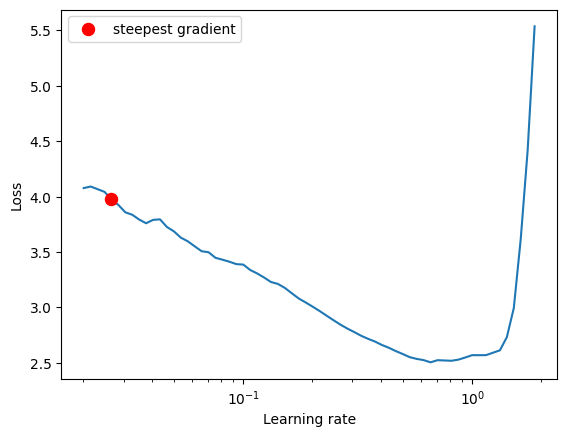

LRMAX: 0.02656087782946686


In [10]:
lr_max,criterion,optimizer = learning_rate_finder.learning_finder(model,train_loader)

# Run the training

In [11]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR, CosineAnnealingLR
train_acc, train_losses, test_acc, test_losses, lrs = [], [], [], [], []

max_lr_epoch = config['max_lr_epoch']
epochs = config['epochs']
## Define Scheduler
scheduler = OneCycleLR(optimizer, max_lr = lr_max,pct_start=max_lr_epoch/epochs, epochs = epochs, steps_per_epoch = len(train_loader))
## Define loss function

for epoch in range(epochs):
    print("EPOCH:", epoch + 1)
    train_test.train(model, device, train_loader, train_acc, train_losses, optimizer, scheduler, criterion, lrs)
    missed_images, missed_labels, missed_predictions = train_test.test(model, device, test_loader, test_acc, test_losses, criterion)

EPOCH: 1


Loss=1.1014963388442993 Batch_id=97 LR=0.00351 Accuracy=46.38: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 0.0029, Accuracy: 5161/10000 (51.61%)

EPOCH: 2


Loss=0.8226729035377502 Batch_id=97 LR=0.00990 Accuracy=66.64: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set: Average loss: 0.0027, Accuracy: 6142/10000 (61.42%)

EPOCH: 3


Loss=0.8532325029373169 Batch_id=97 LR=0.01780 Accuracy=70.57: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0020, Accuracy: 6877/10000 (68.77%)

EPOCH: 4


Loss=0.6137313842773438 Batch_id=97 LR=0.02416 Accuracy=76.64: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.0014, Accuracy: 7837/10000 (78.37%)

EPOCH: 5


Loss=0.45450809597969055 Batch_id=97 LR=0.02656 Accuracy=81.36: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0011, Accuracy: 8105/10000 (81.05%)

EPOCH: 6


Loss=0.4450962543487549 Batch_id=97 LR=0.02638 Accuracy=84.77: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0015, Accuracy: 7709/10000 (77.09%)

EPOCH: 7


Loss=0.4443962574005127 Batch_id=97 LR=0.02583 Accuracy=86.25: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.0010, Accuracy: 8411/10000 (84.11%)

EPOCH: 8


Loss=0.31260156631469727 Batch_id=97 LR=0.02495 Accuracy=87.65: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0009, Accuracy: 8551/10000 (85.51%)

EPOCH: 9


Loss=0.38763347268104553 Batch_id=97 LR=0.02375 Accuracy=89.60: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0009, Accuracy: 8522/10000 (85.22%)

EPOCH: 10


Loss=0.25640350580215454 Batch_id=97 LR=0.02226 Accuracy=90.79: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.0009, Accuracy: 8568/10000 (85.68%)

EPOCH: 11


Loss=0.22346514463424683 Batch_id=97 LR=0.02053 Accuracy=91.86: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.0008, Accuracy: 8798/10000 (87.98%)

EPOCH: 12


Loss=0.14465127885341644 Batch_id=97 LR=0.01859 Accuracy=92.82: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0008, Accuracy: 8819/10000 (88.19%)

EPOCH: 13


Loss=0.1668323278427124 Batch_id=97 LR=0.01652 Accuracy=93.91: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0008, Accuracy: 8779/10000 (87.79%)

EPOCH: 14


Loss=0.16109736263751984 Batch_id=97 LR=0.01435 Accuracy=94.43: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.0007, Accuracy: 8937/10000 (89.37%)

EPOCH: 15


Loss=0.16804151237010956 Batch_id=97 LR=0.01216 Accuracy=95.29: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0007, Accuracy: 8997/10000 (89.97%)

EPOCH: 16


Loss=0.12883803248405457 Batch_id=97 LR=0.01000 Accuracy=96.29: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.0007, Accuracy: 9060/10000 (90.60%)

EPOCH: 17


Loss=0.06172945350408554 Batch_id=97 LR=0.00793 Accuracy=97.00: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0006, Accuracy: 9118/10000 (91.18%)

EPOCH: 18


Loss=0.12153308838605881 Batch_id=97 LR=0.00600 Accuracy=97.48: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0006, Accuracy: 9152/10000 (91.52%)

EPOCH: 19


Loss=0.03876384720206261 Batch_id=97 LR=0.00427 Accuracy=97.90: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0006, Accuracy: 9160/10000 (91.60%)

EPOCH: 20


Loss=0.05232025310397148 Batch_id=97 LR=0.00279 Accuracy=98.30: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.0006, Accuracy: 9206/10000 (92.06%)

EPOCH: 21


Loss=0.043127890676259995 Batch_id=97 LR=0.00159 Accuracy=98.50: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.0006, Accuracy: 9212/10000 (92.12%)

EPOCH: 22


Loss=0.024295009672641754 Batch_id=97 LR=0.00071 Accuracy=98.67: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]



Test set: Average loss: 0.0006, Accuracy: 9217/10000 (92.17%)

EPOCH: 23


Loss=0.04970421642065048 Batch_id=97 LR=0.00018 Accuracy=98.71: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0006, Accuracy: 9241/10000 (92.41%)

EPOCH: 24


Loss=0.029853353276848793 Batch_id=97 LR=0.00000 Accuracy=98.84: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0006, Accuracy: 9233/10000 (92.33%)



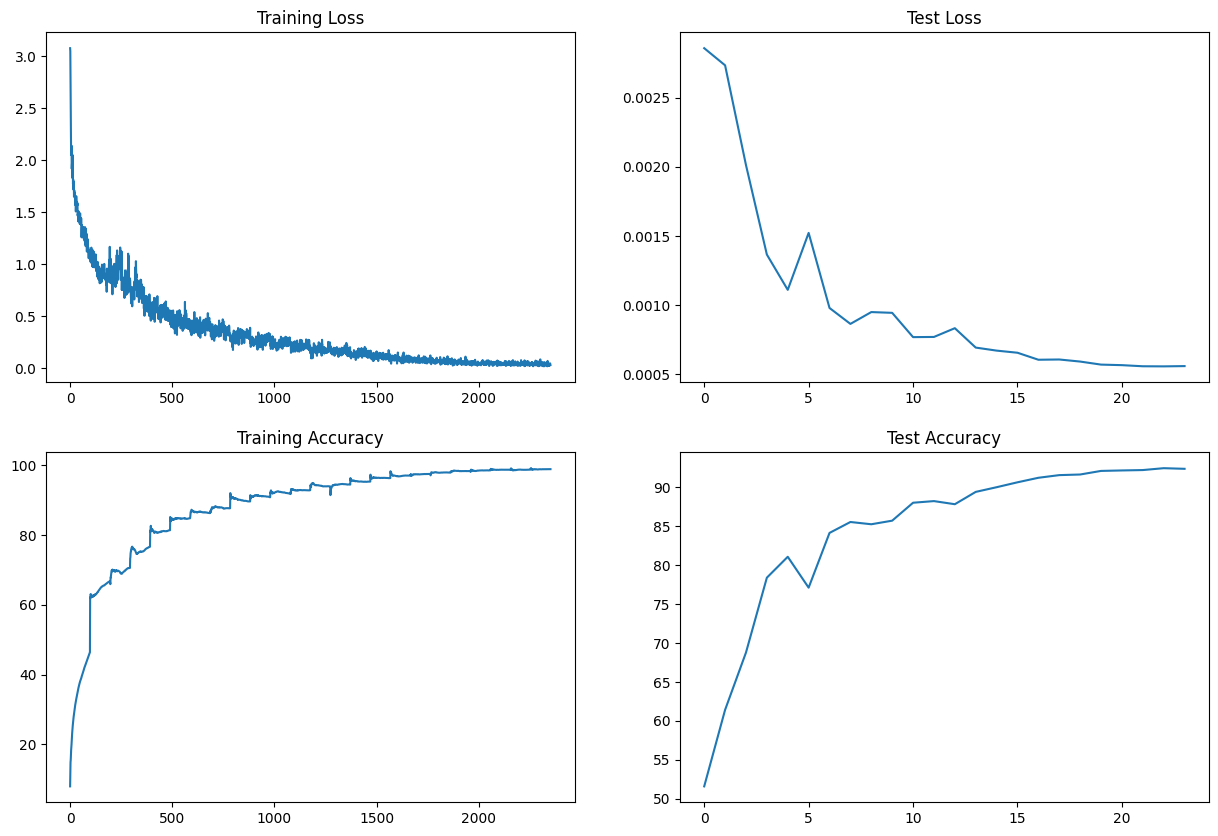

In [12]:
visulatization.show_accuracy_loss(train_losses, train_acc, test_losses, test_acc)

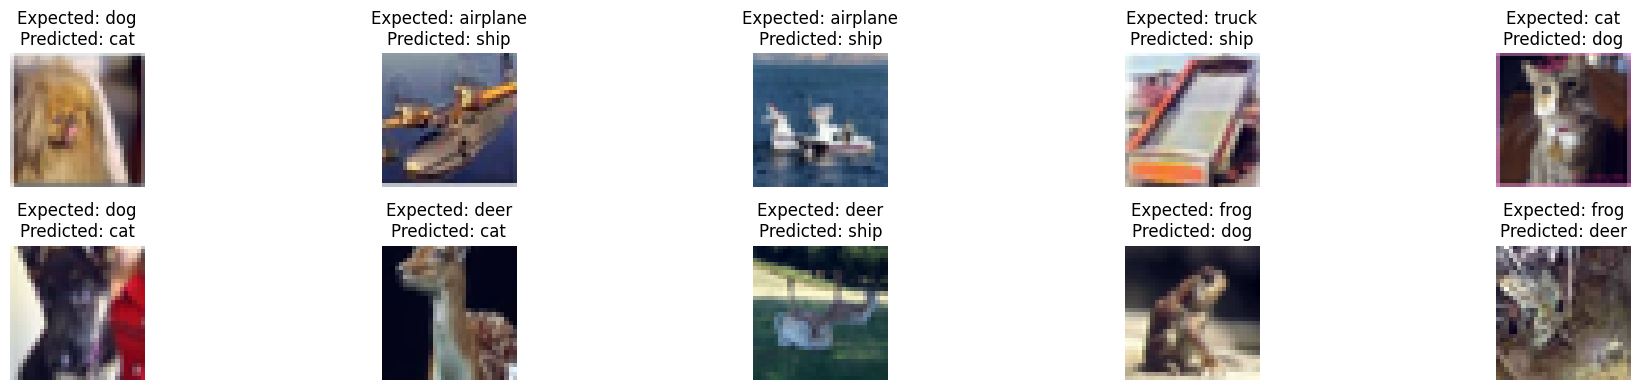

In [13]:
visulatization.show_misclassified_img(missed_images, missed_labels, missed_predictions, classes)

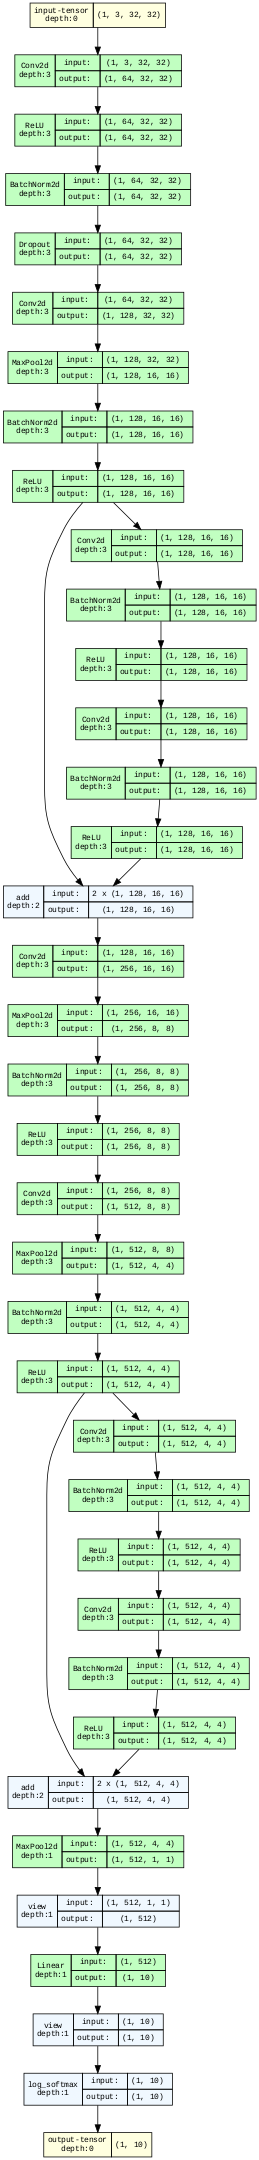

In [14]:
import torchvision
!pip install torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(custom_resnet.Net(), input_size=(1,3,32,32), expand_nested=False)
model_graph.visual_graph